<p style="font-size:small; color:gray;"> Author: 鄭永誠, Year: 2024 </p>

# C3 - 基於LLM發展出來的的AI工具
----------

若你的開發系統想要結合更多資訊，如找新聞、爬指定網頁等，可多留意現在也有很多AI整合的工具，  

很多是別人寫好的可以參考，我這邊就只是隨便拿幾個別人寫好的自己拿來使用範例  

主要是要強調，善用資源的重要性!!!

----------
## # open-interpreter
https://github.com/OpenInterpreter/open-interpreter

- 允許LLM在本地運行程式碼（Python、Javascript、Shell...）

- 可以透過終端機中類似 ChatGPT 的介面與 Open Interprete

- 允許用戶通過自然語言命令與他們的電腦互動 

- 知道有這個就好，我就不具演示


In [2]:
""" 在環境下安裝套件 """
%pip install open-interpreter -q
# 在該環境下終端機輸入 interpreter 即可使用

Note: you may need to restart the kernel to use updated packages.


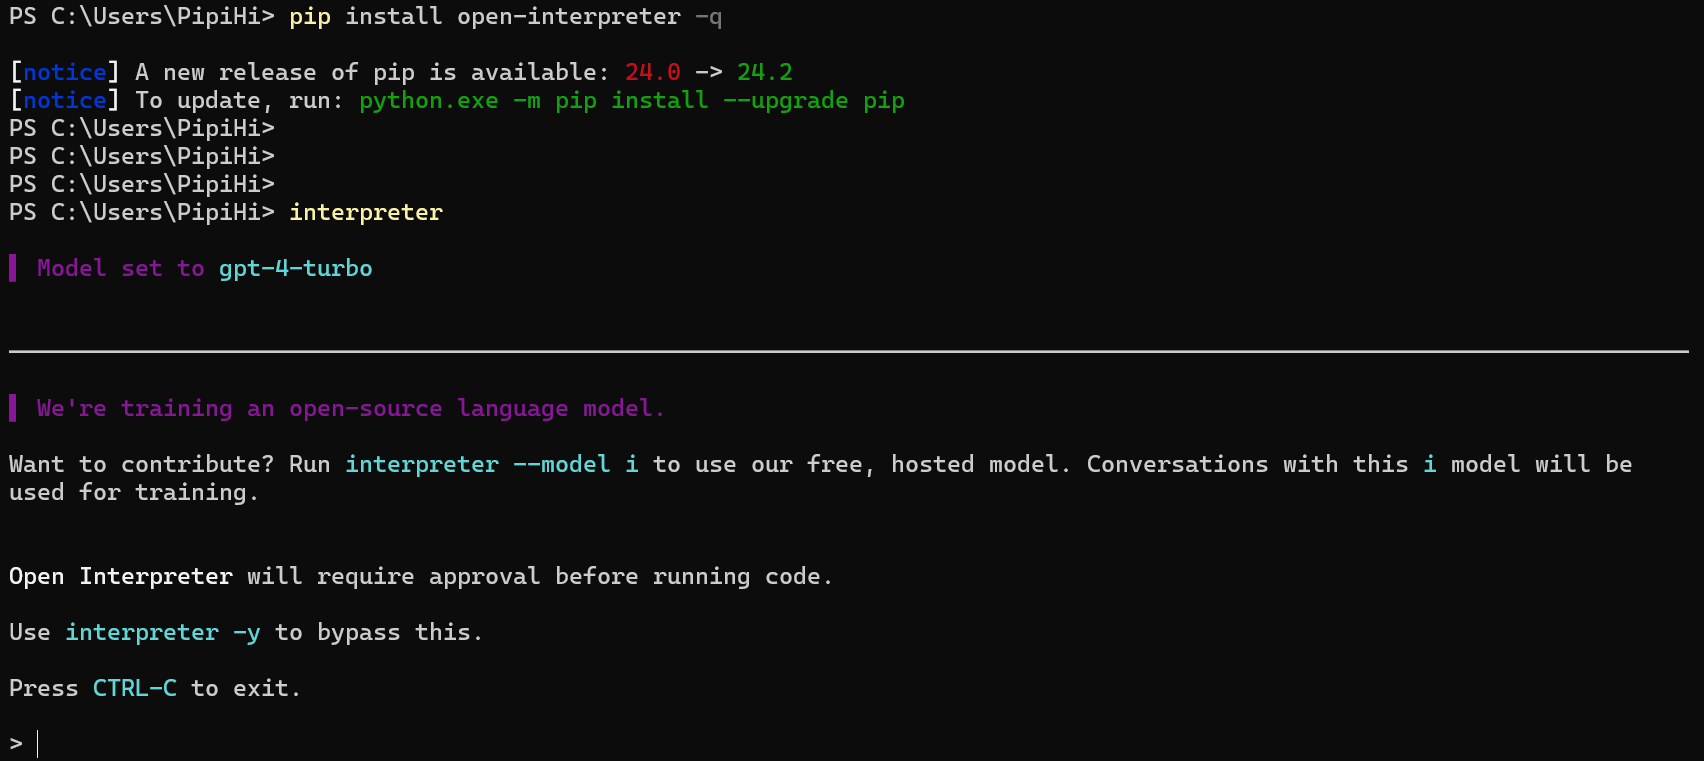

執行會如上圖，就能開始選擇模型(輸入open API key、選擇本地模型等)、進行操作

In [3]:
""" FastAPI 伺服器範例 """

from fastapi import FastAPI
from fastapi.responses import StreamingResponse
from interpreter import interpreter

app = FastAPI()

@app.get("/chat")
def chat_endpoint(message: str):
    def event_stream():
        for result in interpreter.chat(message, stream=True):
            yield f"data: {result}\n\n"

    return StreamingResponse(event_stream(), media_type="text/event-stream")

@app.get("/history")
def history_endpoint():
    return interpreter.messages

----------
## # databonsai 
https://github.com/databonsai/databonsai  

使用 LLM 執行資料清理任務的 Python 函式庫

其實這自己實踐也很簡單，但使用、參考別人寫好的範例也不錯

注意: 這裡的官方實作需要使用openAI，所以我自己定義了一個新的使用groq的程式函示

In [2]:
""" Install dependencies """
%pip install databonsai -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\PipiHi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [18]:
""" 我直接自定義了一個groq_provider，用來封裝Groq的API，並且支援重試機制。 """
import os
from typing import Optional
from groq import Groq
from tenacity import retry, stop_after_attempt, wait_exponential
from functools import wraps
import logging
from abc import ABC, abstractmethod
from databonsai.llm_providers import LLMProvider

logger = logging.getLogger(__name__)

# 原項目並沒提供GroqProvider，所以我按照他格式自己實作了一個
class GroqProvider(LLMProvider):
    """
    A provider class to interact with Groq's API.
    Supports exponential backoff retries for handling large datasets.
    """

    def __init__(
        self,
        api_key: Optional[str] = None,
        multiplier: int = 1,
        min_wait: int = 1,
        max_wait: int = 30,
        max_tries: int = 5,
        model: str = "llama-3.1-70b-versatile",
        temperature: float = 0,
    ):
        """
        Initializes the GroqProvider with an API key and retry parameters.

        Parameters:
        api_key (str): Groq API key.
        multiplier (int): The multiplier for the exponential backoff in retries.
        min_wait (int): The minimum wait time between retries.
        max_wait (int): The maximum wait time between retries.
        max_tries (int): The maximum number of attempts before giving up.
        model (str): The default model to use for text generation.
        temperature (float): The temperature parameter for text generation.
        """
        # Provider related configs
        if api_key:
            self.api_key = api_key
        else:
            self.api_key = os.getenv("GROQ_API_KEY")
            if not self.api_key:
                raise ValueError("Groq API key not provided.")
        self.model = model
        self.client = Groq(api_key=self.api_key)
        self.temperature = temperature
        self.input_tokens = 0
        self.output_tokens = 0

        # Retry related configs
        self.multiplier = multiplier
        self.min_wait = min_wait
        self.max_wait = max_wait
        self.max_tries = max_tries

    def retry_with_exponential_backoff(method):
        """
        Decorator to apply retry logic with exponential backoff to an instance method.
        """
        @wraps(method)
        def wrapper(self, *args, **kwargs):
            retry_decorator = retry(
                wait=wait_exponential(
                    multiplier=self.multiplier, min=self.min_wait, max=self.max_wait
                ),
                stop=stop_after_attempt(self.max_tries),
            )
            return retry_decorator(method)(self, *args, **kwargs)
        return wrapper

    @retry_with_exponential_backoff
    def generate(
        self, system_prompt: str, user_prompt: str, max_tokens: int = 1000
    ) -> str:
        """
        Generates a text completion using Groq's API, with a given system and user prompt.
        This method is decorated with retry logic to handle temporary failures.

        Parameters:
        system_prompt (str): The system prompt to provide context or instructions for the generation.
        user_prompt (str): The user's prompt, based on which the text completion is generated.
        max_tokens (int): The maximum number of tokens to generate in the response.

        Returns:
        str: The generated text completion.
        """
        if not system_prompt:
            raise ValueError("System prompt is required.")
        if not user_prompt:
            raise ValueError("User prompt is required.")
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt},
                ],
                temperature=self.temperature,
                max_tokens=max_tokens,
            )
            # Groq API doesn't provide token usage information, so we can't update input_tokens and output_tokens
            return response.choices[0].message.content
        except Exception as e:
            logger.warning(f"Error occurred during generation: {str(e)}")
            raise

In [27]:
""" databonsai 資料分類操作範例，建立分類器 """
from databonsai.categorize import MultiCategorizer, BaseCategorizer

# 這兩個是官方寫好的，但此處範例我用自己寫的
from databonsai.llm_providers import OpenAIProvider, AnthropicProvider

# 使用自己定義的GroqProvider
api_key = os.getenv("GROQ_API_KEY")
provider = GroqProvider(api_key=api_key)

#  定義類型
categories = {
    "傲嬌": "傲嬌指的是表面上高傲，但內心其實溫柔體貼，經常口是心非的一種性格。",
    "高冷": "那些性格冷淡、難以接近，且在情感上表現得理智克制、不輕易顯露情感的女性角色。",
    "小惡魔": "表面上可愛甜美，卻喜歡調皮捉弄他人，以玩弄別人的感情或挑逗行為來展現魅力的女性角色",
    "元氣": "充滿活力、樂觀開朗，經常是團隊中的精神支柱，性格開朗外向。",
    "天然呆": "天真無邪，有些迷糊，性格溫柔可愛，對周圍的一切都沒有戒心。",
    "大小姐": "出身高貴、優雅端莊，很有品味和教養，不太了解世俗價值觀",
}

# 提供範例資料
few_shot_examples = [
    {"example": "哼，我才不關心你呢，只是剛好路過而已！", "response": "傲嬌"},
    {"example": "請不要隨便靠近我，我不喜歡被打擾。", "response": "高冷"},
    {"example": "嘿嘿，不知道這次你能不能猜到我在想什麼呢？", "response": "小惡魔"},
    {"example": "早安！今天也要充滿幹勁地加油喔！", "response": "元氣"},
    {"example": "咦？剛才你說什麼？抱歉我沒聽清楚。", "response": "天然呆"},
    {"example": "哼，這種小事根本不值得我出手，不過就勉為其難幫你吧。", "response": "大小姐"}
]

# 將資料進行分類
categorizer = BaseCategorizer(
    categories=categories,
    llm_provider=provider,
    examples = few_shot_examples,
    #strict = False # Default true, set to False to allow for categories not in the provided dict
)

In [28]:
""" 範例問題展示 """
category = categorizer.categorize("這樣的問題你也敢問我？真是沒眼光")
print("這句話應該是出自:" , category)

這句話應該是出自: 傲嬌


----------
## # ScrapeGraphAI

透過輸入問題/指令，自己撈取網頁下對應的需求資訊

In [1]:
%pip install scrapegraphai -q
%pip uninstall nest-asyncio -q
%pip install nest-asyncio==1.5.3 -q


Note: you may need to restart the kernel to use updated packages.


In [1]:
""" 
透過ScrapeGraphAI的SmartScraperGraph來擷取網頁資料
!!!! Jupyter Notebook 無法執行此程式碼，請在py檔上執行此範例 !!!!
"""


import json
from scrapegraphai.graphs import SmartScraperMultiGraph
import nest_asyncio  # Import nest_asyncio module for asynchronous operations
nest_asyncio.apply()  # Apply nest_asyncio to resolve any issues with asyncio event loop


# 我這邊搭配使用groq提供的免費LLM api
groq_key = "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"
graph_config = {
    "llm": {"model": "groq/gemma-7b-it", "api_key": groq_key, "temperature": 0.5},
    "verbose": True,
    "headless": False,
    "embeddings": {"model": "ollama/nomic-embed-text"},
}

# 官網範例
multiple_search_graph = SmartScraperMultiGraph(
    prompt="簡禎富擔任過哪些職務?",
    source=[
        f"https://sites.google.com/gapp.nthu.edu.tw/2023/%E7%B0%A1%E7%A6%8E%E5%AF%8C%E5%89%AF%E6%A0%A1%E9%95%B7/",
    ],
    schema=None,
    config=graph_config,
)

result = multiple_search_graph.run()
# print(result)
print(json.dumps(result, indent=4, ensure_ascii=False))


C:\Users\PipiHi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\google_crc32c\__init__.py:29: RuntimeWarning: As the c extension couldn't be imported, `google-crc32c` is using a pure python implementation that is significantly slower. If possible, please configure a c build environment and compile the extension
  warnings.warn(_SLOW_CRC32C_WARNING, RuntimeWarning)
C:\Users\PipiHi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The function `init_chat_model` is in beta. It is actively being worked on, so the API may change.
  warn_beta(
--- Executing GraphIterator Node with batchsize 16 ---
processing graph instances:   0%|          | 0/1 [00:00<?, ?it/s]--- Executing Fetch Node ---
--- (Fetching HTML from: https://sites.google.com/gapp.nthu.edu.tw/2023/%E7%B0%A1%E7%A6%8E%E5

NotImplementedError: 